**Name:** LIU,HONGYANG

**Matric Number:** 17201091/1

5. You are required to write code to implement either time-series clustering or density-based clustering model using the above dataset (Question 1). If you select density-based clustering approach to achieve the task, you are going to cover the following steps:
    - Importing required libraries
    - Load the dataset (Question 1)  into a DataFrame object
    - Visualize the data, use only two of these attributes at the time
    - You may need to normalise the attribute if necessary
    - Show positive correlation between attributes if necessary
    - Construct a density-based clustering model and extract cluster labels and outliers to plot your results. 


### Importing required libraries

In [1]:
import pandas as pd
import seaborn as sns, numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from collections import Counter

### Load the dataset (Question 1)  into a DataFrame object

In [2]:
# In question 1, we have crawled the datasets and stored in csv files
customer=pd.read_csv("customer.csv",header=0,index_col=0)
transactions=pd.read_csv("transactions.csv",header=0,index_col=0)
product=pd.read_csv("product.csv",header=0,index_col=0)

In [3]:
# we need to merge the data sets

#1 merge "product" and "transactions" table and create the table "prod_tran"
product=product.rename(columns={"pro_cat_code":"prod_cat_code"})
prod_tran = pd.merge(left=transactions, right=product,
                     on=["prod_cat_code","prod_subcat_code"],how="left")

In [4]:
#2 merge "prod_tran" and "customer" table and create the table "df"
df= pd.merge(left=prod_tran, right=customer,right_on="customer_id", 
             left_on="customer_id", how="left").drop_duplicates()

In [5]:
#calculate the customers's age column using tran_date(transaction date) and DOB attributes(Date or birth)

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df.insert(loc=3, column='Tran_year', value= df.transaction_date.dt.year)


df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df.insert(loc=4, column='Birth_year', value= df.DOB.dt.year)



df['Tran_year']=df['Tran_year'].astype(int)
df['Birth_year']=df['Birth_year'].astype(int)

df["age"]=df['Tran_year'] -df['Birth_year']

df= df.drop(['Tran_year','Birth_year'],axis=1)

# check the new age column value 
df.age.head()

0    33
1    41
2    22
3    33
4    22
Name: age, dtype: int64

In [6]:
# remove null value
df = df.dropna()

#drop duplicate value
df =df.drop_duplicates()


print("total numer of value:",len(df))
df.head()

total numer of value: 5952


,transaction_id,customer_id,transaction_date,prod_cat_code,prod_subcat_code,Quantity,Price,Tax,Total_amount,Store_type,pro_cat,prod_subcat,DOB,Gender,City_id,City,age
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Women,1981-09-26,M,5.0,Anqing,33
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,Books,Comics,1973-11-05,F,8.0,Chaohu,41
10,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,Books,Comics,1973-11-05,F,8.0,Chaohu,41
14,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,Electronics,Computers,1970-06-26,F,10.0,Chuzhou,44
17,25963520987,274829,2014-02-20,4,4,3,502,158.130,1664.130,Flagship store,Bags,Women,1984-05-09,F,2.0,Chongqing,30


### Visualize the data, use only two of these attributes at the time

In [7]:
Features=["Gender","Total_amount","prod_cat_code","prod_subcat_code","Quantity"
          ,"Price","Tax","Store_type","City_id","age"]

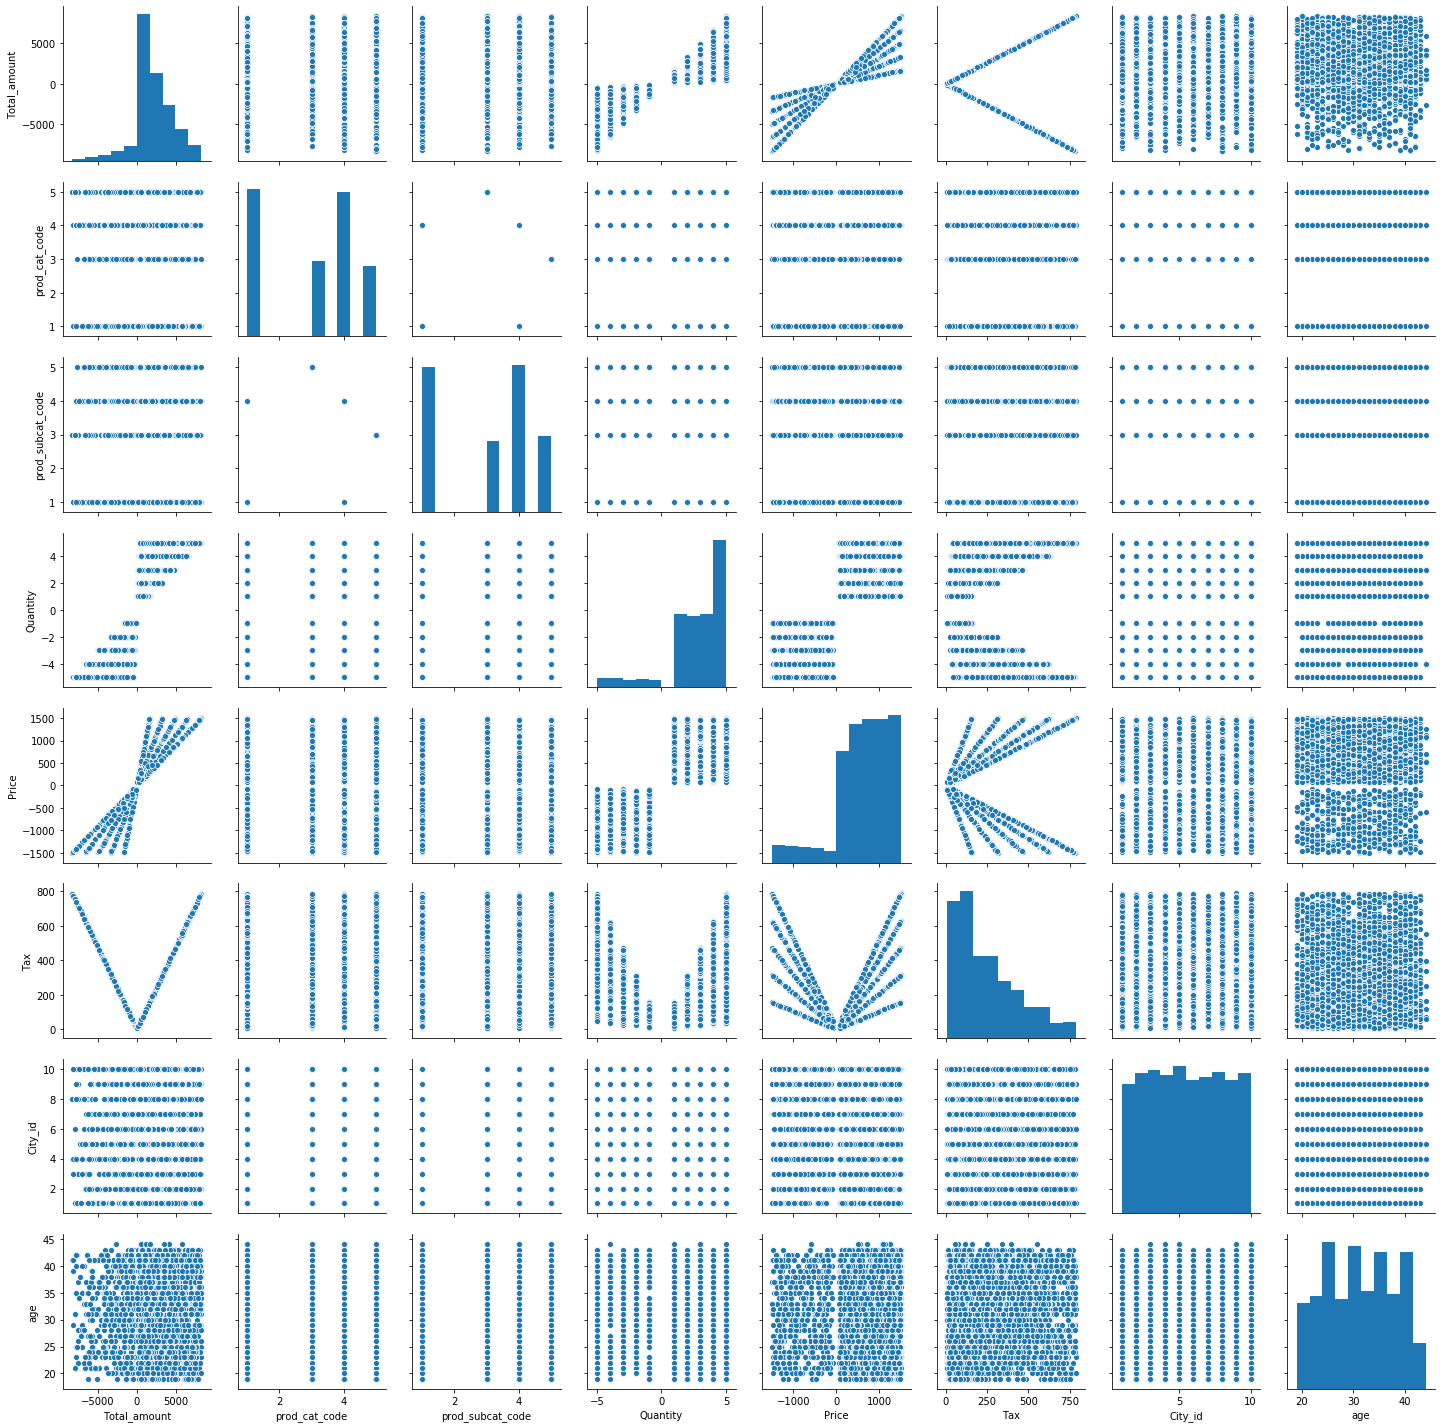

In [8]:
#  use pairplot, we could found the relationship between any of two attributes.
ax = sns.pairplot(df[Features])

Text(0.5, 1, 'Price vs Tax')

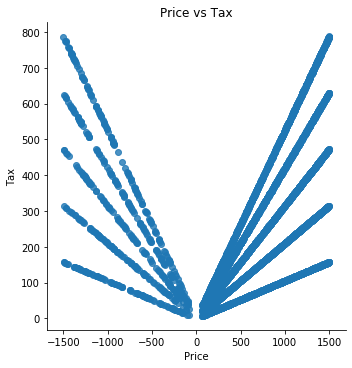

In [9]:
#for more detail, we could use lmplot to visualize any two attributes from the above abservation. 
#e.g. Prive vs Tax
sns.lmplot('Price','Tax', data=df,fit_reg=False)
plt.title('Price vs Tax')

Text(0.5, 1, 'age vs Total_amount')

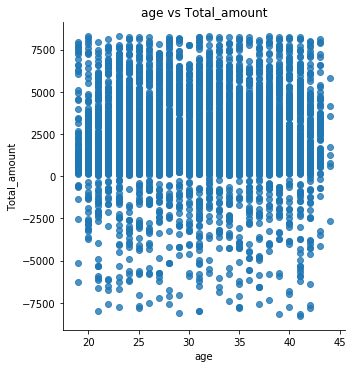

In [10]:
#e.g. age vs Total_amount
sns.lmplot('age','Total_amount', data=df,fit_reg=False)
plt.title('age vs Total_amount')

Text(0.5, 1, 'Price vs Total_amount')

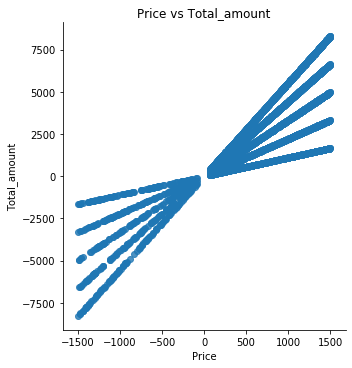

In [11]:
#e.g. Price vs Total_amount
sns.lmplot('Price','Total_amount', data=df,fit_reg=False)
plt.title('Price vs Total_amount')

### You may need to normalise the attribute if necessary

In [12]:
X=df[Features]

# format the categorical features
X= pd.get_dummies(X)
column = X.columns
X.head()

,Total_amount,prod_cat_code,prod_subcat_code,Quantity,Price,Tax,City_id,age,Gender_F,Gender_M,Store_type_Flagship store,Store_type_MBR,Store_type_TeleShop,Store_type_e-Shop
0,-4265.300,1,1,-5,-772,405.300,5.0,33,0,1,0,0,0,1
1,-8270.925,5,3,-5,-1497,785.925,8.0,41,1,0,0,0,0,1
10,8270.925,5,3,5,1497,785.925,8.0,41,1,0,0,0,0,1
14,4153.695,3,5,3,1253,394.695,10.0,44,1,0,0,0,0,1
17,1664.130,4,4,3,502,158.130,2.0,30,1,0,1,0,0,0


In [13]:
# we need normalise the attributes to rescale the data into a range of [0;1]
# normalise the data
data=preprocessing.scale(X)

print(data)

[[-2.47808294 -1.29827201 -1.31706169 ... -0.5106367  -0.49411249
   1.22637541]
 [-4.03926621  1.32850287 -0.01271041 ... -0.5106367  -0.49411249
   1.22637541]
 [ 2.40788237  1.32850287 -0.01271041 ... -0.5106367  -0.49411249
   1.22637541]
 ...
 [ 1.67703326  0.67180915  0.63946523 ... -0.5106367  -0.49411249
   1.22637541]
 [-0.57796139  1.32850287 -0.01271041 ... -0.5106367  -0.49411249
   1.22637541]
 [-0.52412749  0.67180915 -1.31706169 ... -0.5106367  -0.49411249
   1.22637541]]


In [14]:
normalized = pd.DataFrame(data,columns=column)

In [15]:
#normalizased results
normalized.head()

,Total_amount,prod_cat_code,prod_subcat_code,Quantity,Price,Tax,City_id,age,Gender_F,Gender_M,Store_type_Flagship store,Store_type_MBR,Store_type_TeleShop,Store_type_e-Shop
0,-2.478083,-1.298272,-1.317062,-3.202390,-2.217420,0.813484,-0.176899,0.299016,-0.961105,0.961105,-0.496217,-0.510637,-0.494112,1.226375
1,-4.039266,1.328503,-0.012710,-3.202390,-3.363152,2.824340,0.873901,1.509519,1.040469,-1.040469,-0.496217,-0.510637,-0.494112,1.226375
2,2.407882,1.328503,-0.012710,1.121807,1.368326,2.824340,0.873901,1.509519,1.040469,-1.040469,-0.496217,-0.510637,-0.494112,1.226375
3,0.803201,0.015115,1.291641,0.256967,0.982728,0.757457,1.574434,1.963458,1.040469,-1.040469,-0.496217,-0.510637,-0.494112,1.226375
4,-0.167101,0.671809,0.639465,0.256967,-0.204092,-0.492325,-1.227698,-0.154923,1.040469,-1.040469,2.015248,-0.510637,-0.494112,-0.815411


### Show positive correlation between attributes if necessary

The positive correlation Quantity and Total_amount is 0.8003219115488281
The positive correlation Price and Total_amount is 0.8340578740872245
The positive correlation Tax and Total_amount is 0.6004325840445992


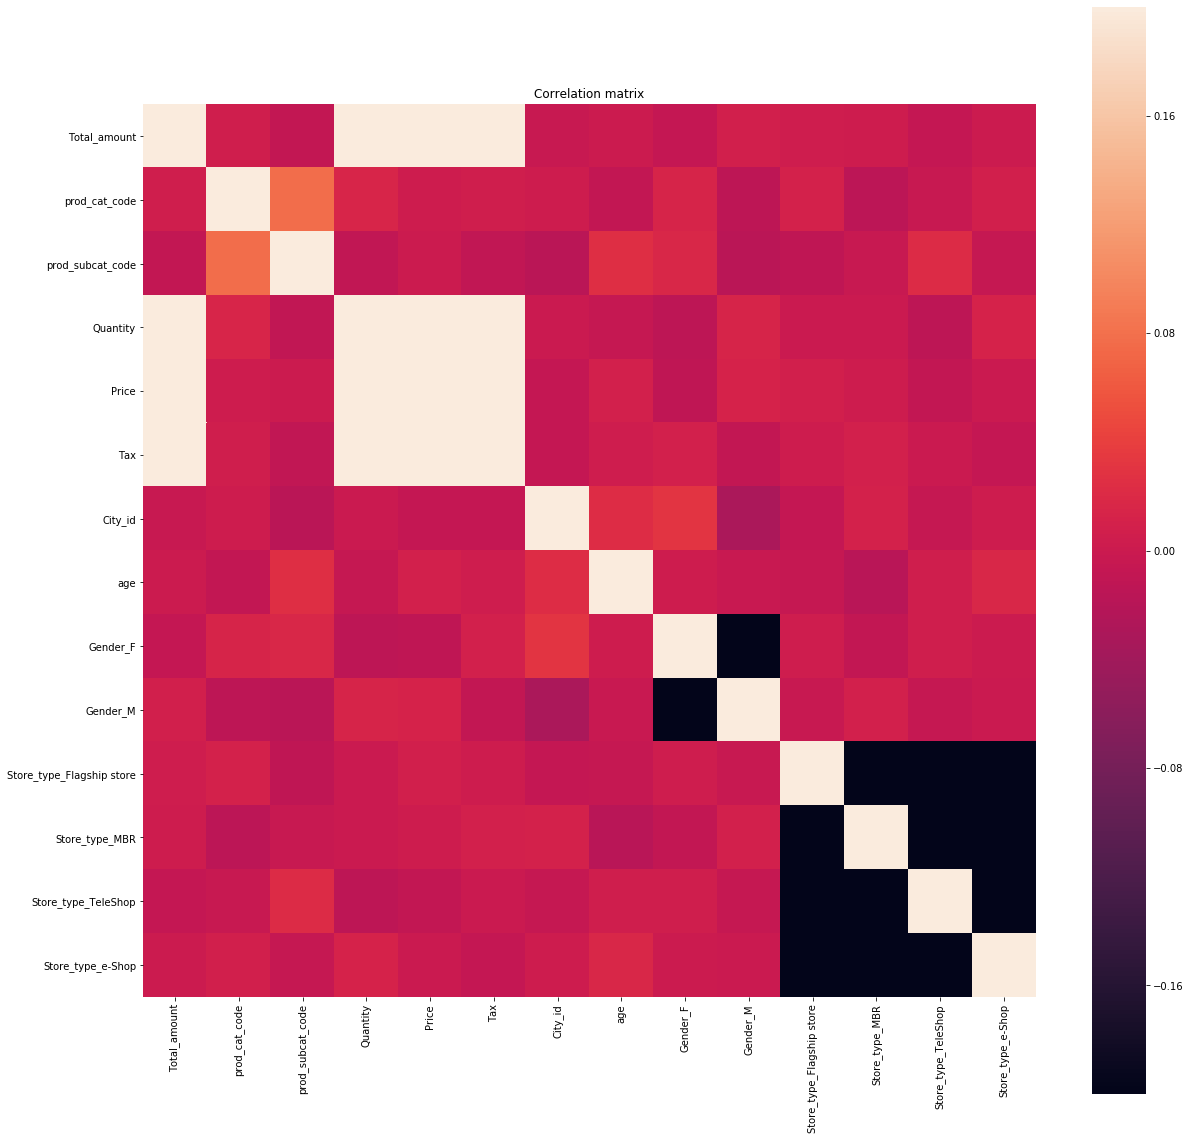

In [16]:
# Show positive correlation between attributes if necessary
plt.figure(figsize=(20,20))
corr = normalized.corr()
mask = np.zeros_like(corr)
sns.heatmap(corr, mask=mask, square=True, vmin=-.20, vmax=.20)
plt.title('Correlation matrix')
Quantity = normalized['Quantity']
Total_amount= normalized['Total_amount']
Price= normalized['Price']
Tax = normalized['Tax']
print("The positive correlation Quantity and Total_amount is {}".format((np.corrcoef(Quantity,Total_amount)[0][1])))
print("The positive correlation Price and Total_amount is {}".format((np.corrcoef(Price,Total_amount)[0][1])))
print("The positive correlation Tax and Total_amount is {}".format((np.corrcoef(Tax,Total_amount)[0][1])))

### Construct a density-based clustering model and extract cluster labels and outliers to plot your results. 

#####  data attributes reduction using PCA

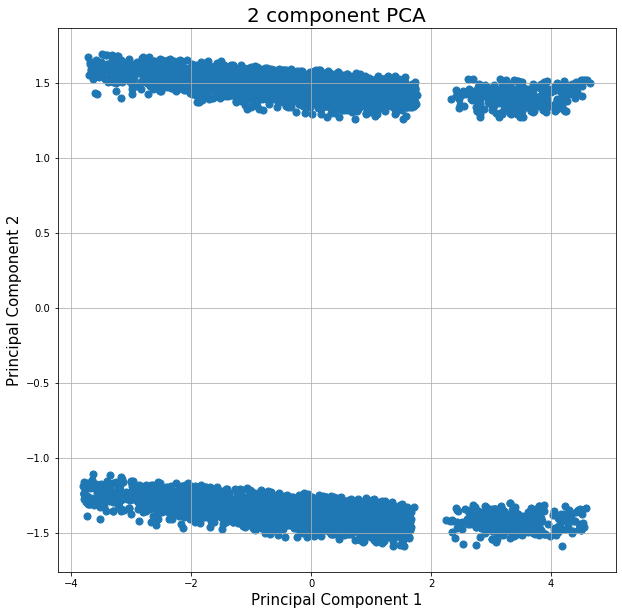

In [19]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized)
Df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


ax.scatter(Df.loc[:, 'principal component 1']
               , Df.loc[:, 'principal component 2']
               , s = 50)

ax.grid()

##### Construct a density-based clustering model

In [20]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.2, min_samples=30).fit(Df)
print(model)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)


In [21]:
model.labels_

array([ 0, -1,  1, ...,  2,  1,  2])

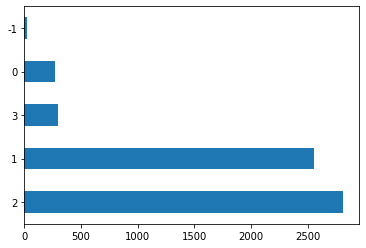

In [22]:
label = pd.Series(model.labels_)
label.value_counts().plot('barh')

##### extract cluster labels and outliers

In [23]:
# Separate outliers from clustered data
labels = model.labels_
# outlier label
outlier_label = labels[labels == -1]

# outlier datasets
outliers = Df[model.labels_==-1]

print("outlier label",outlier_label)
print("outlier datasets",outliers)

outlier label [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
outlier datasets       principal component 1  principal component 2
1                  4.650896               1.500162
185                2.439860              -1.424890
320                2.316771              -1.422262
1061               4.578399               1.524293
1147               2.350315              -1.414885
1155               2.518166              -1.475661
1244               4.583476              -1.331115
1655               2.438717              -1.347964
2176               2.463997               1.335942
2520               2.405861              -1.533217
2785               2.425541               1.455934
3003               2.254496              -1.414128
3178               2.534400              -1.572072
3726               2.443787              -1.352899
3841               2.434725              -1.467377
3871               2.410285               1.414323
4119               4.601857          

In [24]:
#normal data's labels
clusters_label = labels[labels!= -1]

#normal data sets
data_points =  Df[model.labels_!=-1]


print("normal data's labels",clusters_label)

print("normal data sets",data_points)

normal data's labels [0 1 1 ... 2 1 2]
normal data sets       principal component 1  principal component 2
0                  3.833851              -1.479378
2                 -3.716450               1.674018
3                 -1.342601               1.620884
4                  0.287023               1.447791
5                 -1.223904               1.571504
6                  1.768253               1.419171
7                 -1.520127              -1.376995
8                  2.762943               1.386558
9                 -2.561002              -1.241520
10                 0.737773              -1.318933
11                 0.704626               1.537232
12                -2.644574               1.549945
13                 1.544028              -1.404997
14                 0.372688              -1.400864
15                -1.195361              -1.311780
16                 1.247473              -1.479391
17                -1.444831               1.594930
18                 0.24274

**Outlier label:** -1

**Normal data sets label:** 0, 1, 2, 3,

##### plot your results

/Users/liuhongyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


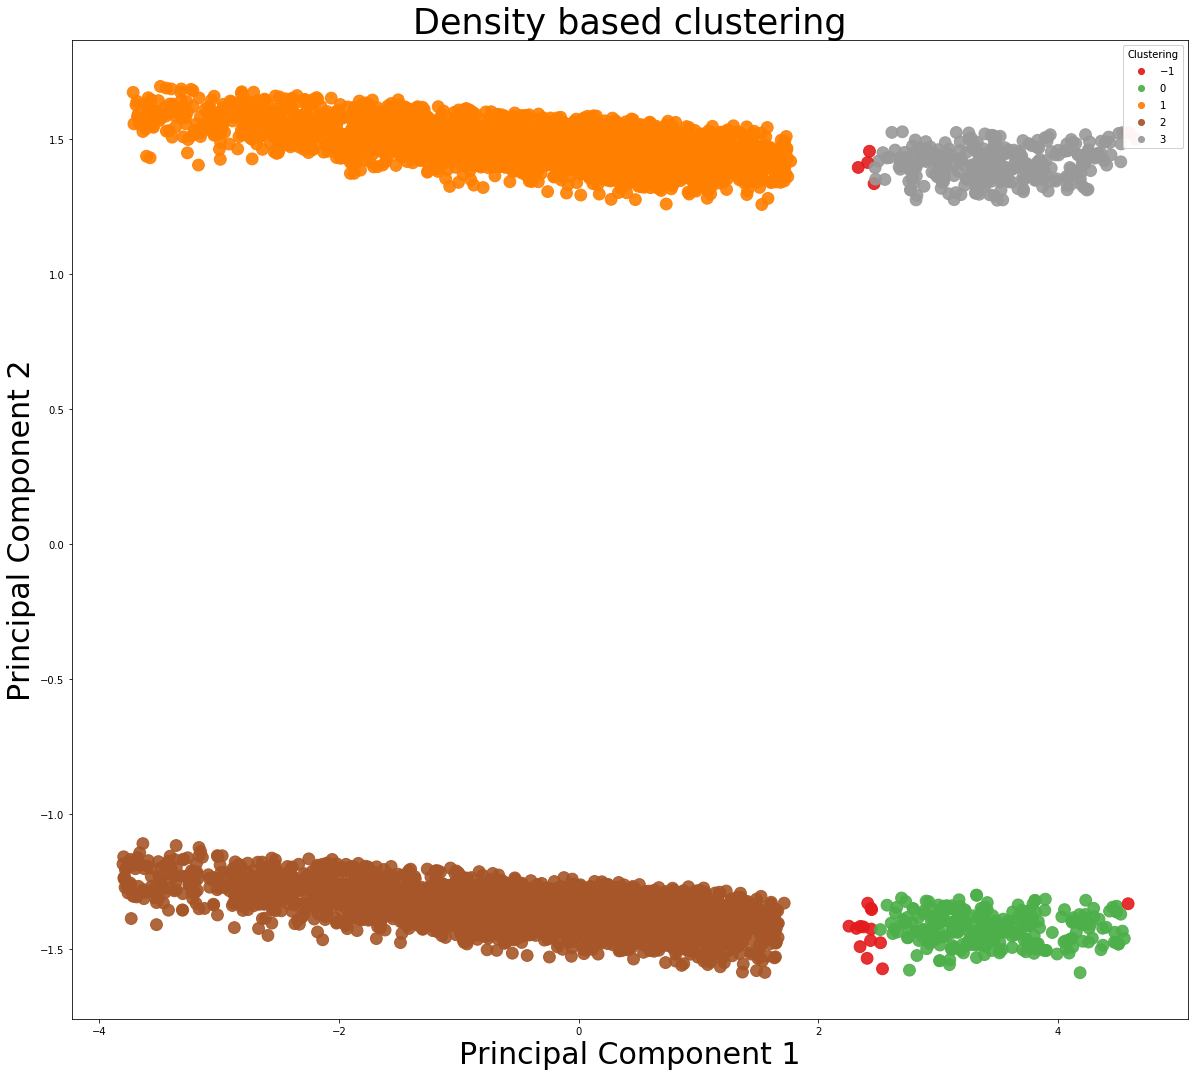

In [25]:
fig, ax = plt.subplots(figsize=(20,18))
scatter = ax.scatter(Df.iloc[:,0],Df.iloc[:,1],c=model.labels_,s =140,alpha=0.9,cmap=plt.cm.Set1)

ax.set_xlabel("Principal Component 1",fontsize= 30)
ax.set_ylabel("Principal Component 2",fontsize= 30)

plt.title("Density based clustering",fontsize= 35)


legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clustering")

ax.add_artist(legend)

fig.show()

Base on the model, there are five different clustering, 
   - the labeled - represents outliers 
   - the other four clustering  represents normal data sets

###### configure the eps to find more results

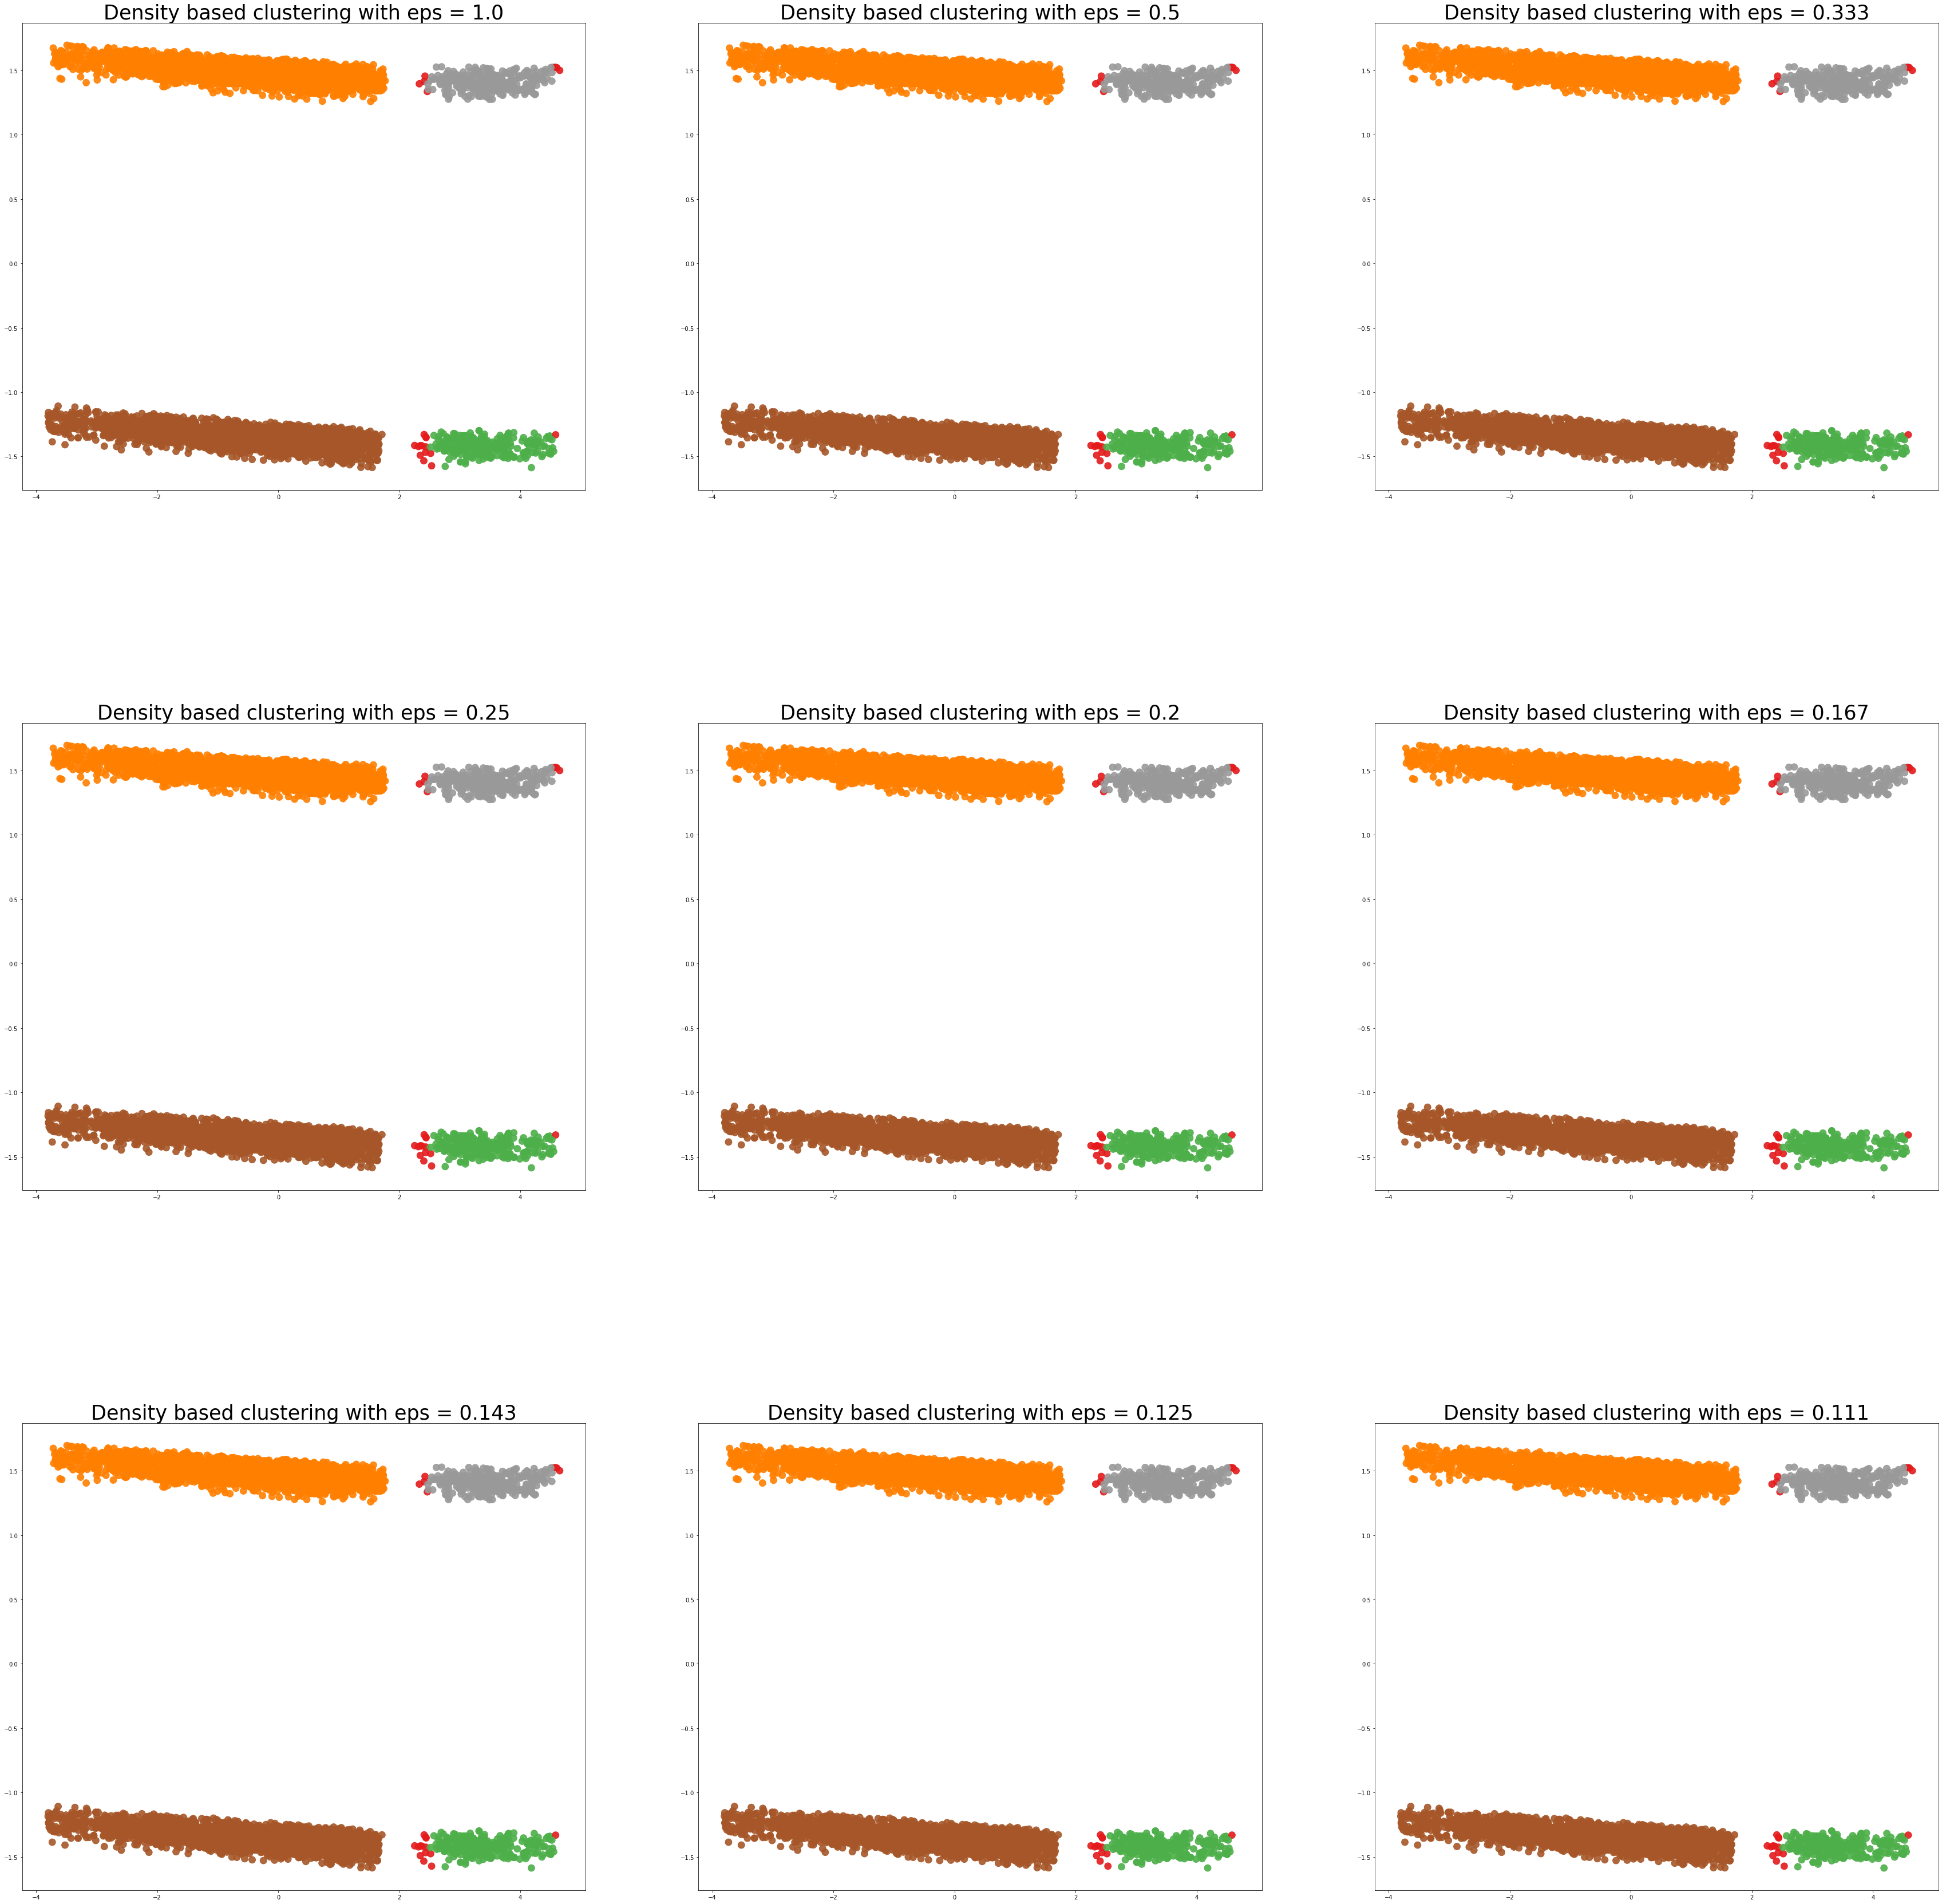

In [26]:
fig = plt.figure(figsize=(60, 60))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 1, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=20).fit(Df)
    
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    
    core_samples_mask[db.core_sample_indices_] = True
    
    ax = fig.add_subplot(3, 3, i)
    
    plt.title("Density based clustering with eps = {}".format(round(eps, 3)),fontsize= 35 )
    
    
    sctr = ax.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1],c=model.labels_, s=140,alpha=0.9,cmap=plt.cm.Set1)
    
    i += 1
